<h3>Primero se leen los datos generados en el paso previo</h3>

In [5]:
import warnings, json, numpy as np, pandas as pd

ruta = 'C://TweetsPositivosMuertes.csv'
df = pd.read_csv(ruta, header=0)
df.head(10)

,Fecha,Polarity,Positivos,Muertes
0,2020-02-28,-0.361114,1,0
1,2020-02-29,-0.204301,1,0
2,2020-03-01,-0.200173,0,0
3,2020-03-02,-0.179771,2,0
4,2020-03-03,-0.153471,3,0
5,2020-03-04,-0.250792,5,0
6,2020-03-05,-0.227617,6,0
7,2020-03-06,-0.159990,1,0
8,2020-03-08,-0.818305,5,0
9,2020-03-09,-0.008387,3,0


<h3>Se presenta primero una visualización sencilla a partir del manejo de una ventana estadística de 14 días
<BR>Este número es tomado considerando el tiempo en que tardan en manifestarse en promedio los síntomas del COVID.
<BR>Se puede apreciar cómo es que ha habido una disminución en las muertes a medida que fue avanzando el plan de vacunación
</h3>

Text(0, 0.5, 'Nuevas muertes diarias')

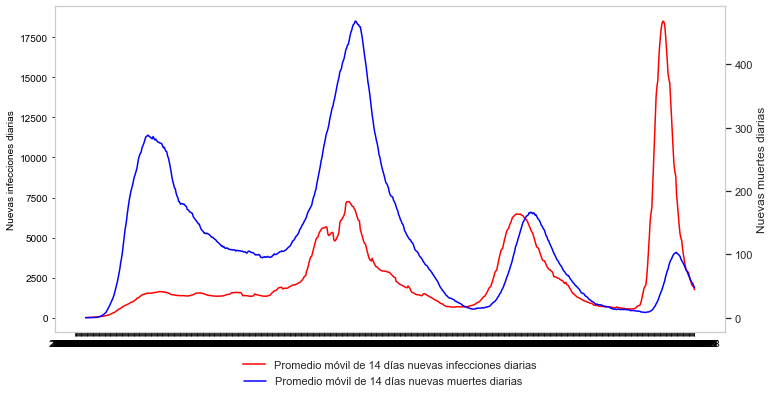

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(figsize=(12,6))
rolling_avg = 14

ax.plot(df.Fecha,df['Positivos'].rolling(window=rolling_avg).mean(),color='red',label='Promedio móvil de 14 días nuevas infecciones diarias')
sns.set()
sns.set_style("whitegrid")
ax.set_ylabel('Nuevas infecciones diarias')

ax2=ax.twinx()
ax2.plot(df.Fecha, df["Muertes"].rolling(window=rolling_avg).mean(), color="blue",label='Promedio móvil de 14 días nuevas muertes diarias')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.10))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.15))
ax2.grid(False)
ax2.set_ylabel('Nuevas muertes diarias')

<h3>Se emplea shift() para trazar la variable Muertes retrasada en el tiempo por un cierto número de días.
<BR>Esto mostrará lo que se supone es la variable de efecto al mismo tiempo en el eje x con lo que se supone que es la variable causal (número de nuevas infecciones).
</h3>

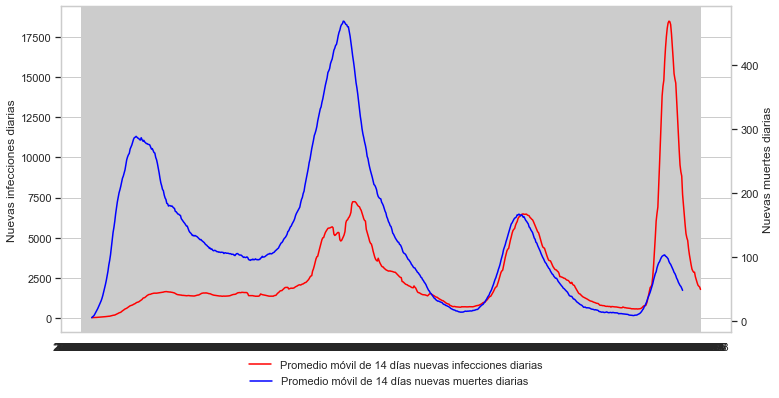

In [9]:
lag = -21
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(df.Fecha,df['Positivos'].rolling(window=rolling_avg).mean(),color='red',label='Promedio móvil de 14 días nuevas infecciones diarias')
ax.set_ylabel('Nuevas infecciones diarias')
ax2=ax.twinx()
ax2.plot(df.Fecha, df["Muertes"].shift(lag).rolling(window=rolling_avg).mean(), color="blue",label='Promedio móvil de 14 días nuevas muertes diarias')
ax2.grid(False)
ax2.set_ylabel('Nuevas muertes diarias')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.10))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.15))

<h3>En este paso se encuentra la relación entre las muertes retrasadas y las infecciones iniciales.<BR>Para esto se crea un factor de predicción de muerte (escalar) para cada día dividiendo la muerte diaria por las infecciones diarias de 21 días antes.
<BR>El valor lag se puede modificar si se desea probar con otra ventana de tiempo.
</h3>

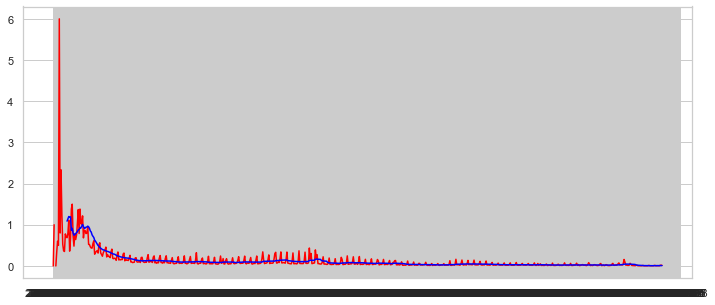

In [10]:
df["escalar_prediccion_muerte"] = df["Muertes"].shift(lag)/df["Positivos"]
fig,ax = plt.subplots(figsize=(12,5))
sns.set()
sns.set_style("whitegrid")
ax.plot(df.Fecha,df['escalar_prediccion_muerte'],color='red')
ax.plot(df.Fecha, df["escalar_prediccion_muerte"].rolling(window=rolling_avg).mean(), color="blue")

<h3>En este paso se calcula una tasa de mortalidad promedio a partir de datos rezagados.
<BR>Se calcula el índice desde el final de los datos para iniciar el cómputo</h3>

In [17]:
avg_death_from_positive_cases = df["escalar_prediccion_muerte"].rolling(window=rolling_avg).mean()
stable_period = 30
start = lag - stable_period # 
death_factor = avg_death_from_positive_cases[start:lag].mean() # 

df['avg_death_factor'] = [death_factor] * len(df.index)
df['predicted_death'] = df['Positivos'] * df['avg_death_factor']

<h3>El factor de muerte se puede usar para predecir futuras muertes en función de las infecciones iniciales.<BR>El dataset se utiliza para crear una nueva columna de datos con las predicciones futuras de 21 días en el futuro basadas en las infecciones diarias iniciales de ese día.
<BR>El gráfico no se aprecia muy bien porque se toma una 'rebanada' de toda la serie de tiempo y los valores no se ajustan a la vista actual.
</h3>

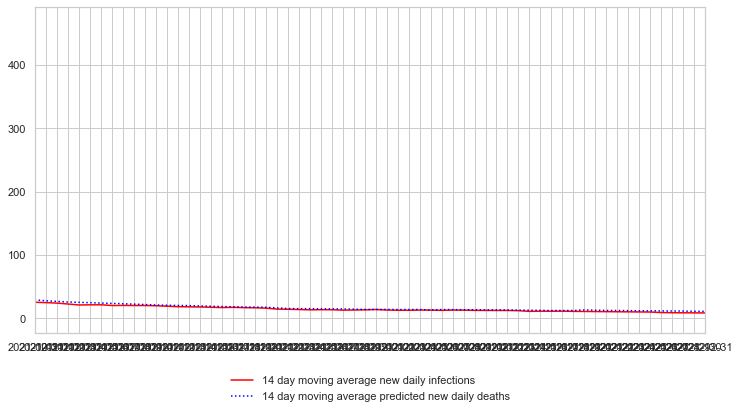

In [18]:
start_date = '2021-10-31'
end_date = '2021-11-30'
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(df.Fecha,df['Muertes'].rolling(window=rolling_avg).mean(),color='red',label='Promedio móvil de 14 días nuevas infecciones diarias')
sns.set()
sns.set_style("whitegrid")
ax.plot(df.Fecha, df['predicted_death'].shift(-lag).rolling(window=rolling_avg).mean(), color="blue",linestyle=":",label='Promedio móvil de 14 días predijo nuevas muertes diarias')
plt.xlim([start_date,end_date])
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.17))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.22))